In [1]:
import os
#list the current work dir
os.getcwd()
#change the current work dir
os.chdir('/home/siyuan/Seafile/Thesis/PycharmProjects/DD_PE_paper/')

In [1]:
from networkx.generators.random_graphs import erdos_renyi_graph
from src.QAOA.QAOA_approximation import generate_three_regular_graph, generate_graph_matrix, create_qaoa_circ, compute_expectation
from scipy.optimize import minimize
import numpy as np

In [2]:
from qiskit import IBMQ, transpile, Aer
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-france', group='univ-montpellier', project='reservations')
backend = provider.get_backend('ibmq_jakarta')

In [6]:
from src.QAOA.QAOA_approximation import get_ansatz_parm
##Construct 3-regular graphs of different degree
weight_matrices = []
graphs = []
circuits = []

for i in range(4, 7, 2):
    G = generate_three_regular_graph(i)
    res = get_ansatz_parm(G)
    print(res)
    qc = create_qaoa_circ(G, res.x)
    w = generate_graph_matrix(G)
    weight_matrices.append(w)
    graphs.append(G)
    circuits.append(qc)
    print('----------')

     fun: -3.693359375
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 33
  status: 1
 success: True
       x: array([52.12044927, 92.93027933])
----------
     fun: -5.3173828125
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 27
  status: 1
 success: True
       x: array([52.14027902, 93.93254817])
----------


In [7]:
## construct randomized graph of different degree
seed = 200
p = 0.5
for i in range(4, 7, 2):
    G = erdos_renyi_graph(i, p, seed)
    res = get_ansatz_parm(G)
    print(res)
    qc = create_qaoa_circ(G, res.x)
    w = generate_graph_matrix(G)
    weight_matrices.append(w)
    graphs.append(G)
    circuits.append(qc)
    print('----------')

     fun: -2.0634765625
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 26
  status: 1
 success: True
       x: array([51.48692938, 93.00036061])
----------
     fun: -6.861328125
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 29
  status: 1
 success: True
       x: array([52.08505957, 92.89675027])
----------


In [15]:
from src.tools.DD_insertion import pm_DD_sequences
from qiskit.transpiler import PassManager, InstructionDurations

durations = InstructionDurations.from_backend(backend)
pms = pm_DD_sequences(durations)

In [16]:
## add duration of y gates which are used for DD sequences
bconf = backend.configuration()
for i in range(bconf.num_qubits):
    x_duration = durations.get('x', i)
    durations.update(InstructionDurations(
        [('y', i, x_duration)]
        ))

    durations.update(InstructionDurations(
        [('rx', i, x_duration)]
        ))

    durations.update(InstructionDurations(
        [('ry', i, x_duration)]
        ))

In [17]:
# Template optimisation for RZZ gate and SWAP gate

from qiskit.circuit.library.standard_gates.equivalence_library import StandardEquivalenceLibrary as std_eqlib

# Transpiler passes
from qiskit.transpiler.passes import Collect2qBlocks
from qiskit.transpiler.passes import ConsolidateBlocks
from qiskit.transpiler.passes import Optimize1qGatesDecomposition
from qiskit.transpiler.passes.basis import BasisTranslator, UnrollCustomDefinitions
from qiskit.transpiler.passes.scheduling.calibration_creators import RZXCalibrationBuilderNoEcho
from qiskit.transpiler.passes.optimization.echo_rzx_weyl_decomposition import EchoRZXWeylDecomposition

In [18]:
inst_map = backend.defaults().instruction_schedule_map
rzx_basis = ['rzx', 'rz', 'x', 'sx']

pm_pulse_efficient = PassManager(
        [
            # Consolidate consecutive two-qubit operations
            Collect2qBlocks(),
            ConsolidateBlocks(basis_gates=['rz', 'sx', 'x', 'rxx']),
            # Rewrite circuit in terms of Cartan-decomposed echoed RZX gates
            EchoRZXWeylDecomposition(inst_map),
            # Calibrations for RZX gates
            RZXCalibrationBuilderNoEcho(backend),
            # Rewrite in rzx basis
            UnrollCustomDefinitions(std_eqlib, rzx_basis),
            BasisTranslator(std_eqlib, rzx_basis),
            Optimize1qGatesDecomposition(rzx_basis)
        ]
    )

In [ ]:
from src.tools.DD_insertion import translate_circuit_to_basis, rzx_gate_recover

In [14]:
## combine template optimisation and dd sequences

job_ids = []
jobs = []

for circuit in circuits:
    circuit_list = []
    seed = 1
    transpiled_qc = transpile(circuit, backend=backend, optimization_level=3, seed_transpiler=seed)
    circuit_list.append(transpiled_qc)
    for pm in pms:
        qc_transpile = pm.run(transpiled_qc)
        qc_transpile_base = translate_circuit_to_basis(qc_transpile, bconf)
        circuit_list.append(qc_transpile_base)

    qc_pulse_efficient = pm_pulse_efficient.run(transpiled_qc)
    qc_pulse_efficient_transpile = rzx_gate_recover(qc_pulse_efficient)
    circuit_list.append(qc_pulse_efficient_transpile)

    qc_pulse_calibrations = qc_pulse_efficient.calibrations
    rzx_durations = []

    for key, value in qc_pulse_calibrations.items():
        rzx_duration = tuple()
        for i, elm in value.items():
            rzx_durations.append((elm.name, list(i[0]), elm.duration))
    durations.update(InstructionDurations(rzx_durations))

    pms2 = pm_DD_sequences(durations)

    for pm in pms2:
        qc_transpile = pm.run(qc_pulse_efficient)
        qc_transpile_base = translate_circuit_to_basis(qc_transpile, bconf)
        qc_transpile = rzx_gate_recover(qc_transpile_base)
        circuit_list.append(qc_transpile)

    job = backend.run(circuit_list, shots=8192)
    jobs.append(job)
    job_id = job.job_id()
    print(job_id)
    job_ids.append(job_id)

if applied DD for None: False
if applied DD for None: False
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
if applied DD for None: False
if applied DD for None: False
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
628762899c97e9fa562aa704
if applied DD for None: False
if applied DD for None: False
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
if applied DD for None: True
if applied DD for None: False
if applied DD for None: False
if applied DD for None: True
if applied

In [8]:
from src.QAOA.QAOA_approximation import expectation_result, get_operator
from qiskit.algorithms import NumPyMinimumEigensolver
shots = 8192

In [9]:
name = ['Original_ideal', 'hahn_X_ideal', 'hahn_Y_ideal', 'cp_ideal', 'cpmg_ideal', 'xy4_ideal', 'xy8_ideal', 'xy16_ideal', 'udd_x_ideal', 'udd_y_ideal', 'KDD_ideal',
        'Original_pe', 'hahn_X_pe', 'hahn_Y_pe', 'cp_pe', 'cpmg_pe', 'xy4_pe', 'xy8_pe', 'xy16_pe', 'udd_x_pe', 'udd_y_pe', 'KDD_pe']

npme = NumPyMinimumEigensolver()

job_ids = [
    '628762899c97e9fa562aa704',
'6287628fe462cec9b25e474c',
'62876292ff7757e32c54bce7',
'6287629bd1d86b121ae4d2eb',
]

graph_name = ['3-regular-4', '3-regular-6',
              'rand-4-0.5', 'rand-6-0.5',]

graph_ratio_results = {}


results_data = {}
for idx, job_id in enumerate(job_ids):
    job = backend.retrieve_job(job_id)
    counts = job.result().get_counts()
    qubit_op, offset, pauli_list = get_operator(weight_matrices[idx])

    approximation_ratios = {}
    exp_val_classical = npme.compute_minimum_eigenvalue(qubit_op).eigenvalue.real
    print(f'--------{graph_name[idx]}----------------')


    approx_ratios =  []
    for i, count in enumerate(counts):
        exp_val_counts = expectation_result(count, shots, pauli_list)
        # print(f'The expectation value of {name[i]} is {exp_val_counts}')

        approximation_ratio = exp_val_counts / exp_val_classical
        approx_ratios.append(approximation_ratio)
        approximation_ratios[name[i]] = approximation_ratio
        print(f'Approximation ratio of {name[i]} is {approximation_ratio}')
    results_data[graph_name[idx]] = approx_ratios
    graph_ratio_results[graph_name[idx]] = approximation_ratios

--------3-regular-4----------------
Approximation ratio of Original_ideal is 0.42431640625
Approximation ratio of hahn_X_ideal is 0.431396484375
Approximation ratio of hahn_Y_ideal is 0.4107666015625
Approximation ratio of cp_ideal is 0.50390625
Approximation ratio of cpmg_ideal is 0.516357421875
Approximation ratio of xy4_ideal is 0.501220703125
Approximation ratio of xy8_ideal is 0.49755859375
Approximation ratio of xy16_ideal is 0.4864501953125
Approximation ratio of udd_x_ideal is 0.507568359375
Approximation ratio of udd_y_ideal is 0.4893798828125
Approximation ratio of KDD_ideal is 0.4808349609375
Approximation ratio of Original_pe is 0.5302734375
Approximation ratio of hahn_X_pe is 0.508544921875
Approximation ratio of hahn_Y_pe is 0.526611328125
Approximation ratio of cp_pe is 0.5118408203125
Approximation ratio of cpmg_pe is 0.4993896484375
Approximation ratio of xy4_pe is 0.505859375
Approximation ratio of xy8_pe is 0.5081787109375
Approximation ratio of xy16_pe is 0.48889160

In [10]:
print(results_data)

{'3-regular-4': [0.42431640625, 0.431396484375, 0.4107666015625, 0.50390625, 0.516357421875, 0.501220703125, 0.49755859375, 0.4864501953125, 0.507568359375, 0.4893798828125, 0.4808349609375, 0.5302734375, 0.508544921875, 0.526611328125, 0.5118408203125, 0.4993896484375, 0.505859375, 0.5081787109375, 0.4888916015625, 0.5189208984375, 0.511962890625, 0.4661865234375], '3-regular-6': [0.2296875, 0.220849609375, 0.216162109375, 0.355908203125, 0.34765625, 0.339892578125, 0.3294921875, 0.343603515625, 0.354443359375, 0.35869140625, 0.290478515625, 0.340576171875, 0.33974609375, 0.339306640625, 0.34482421875, 0.360400390625, 0.361962890625, 0.34189453125, 0.3728515625, 0.3421875, 0.3330078125, 0.378173828125], 'rand-4-0.5': [0.0360107421875, 0.0198974609375, 0.027587890625, 0.0321044921875, 0.027587890625, 0.0009765625, -0.022705078125, -0.0057373046875, 0.0518798828125, -0.0306396484375, -0.07421875, 0.0352783203125, 0.0224609375, 0.0360107421875, -0.01513671875, -0.008056640625, -0.0062255

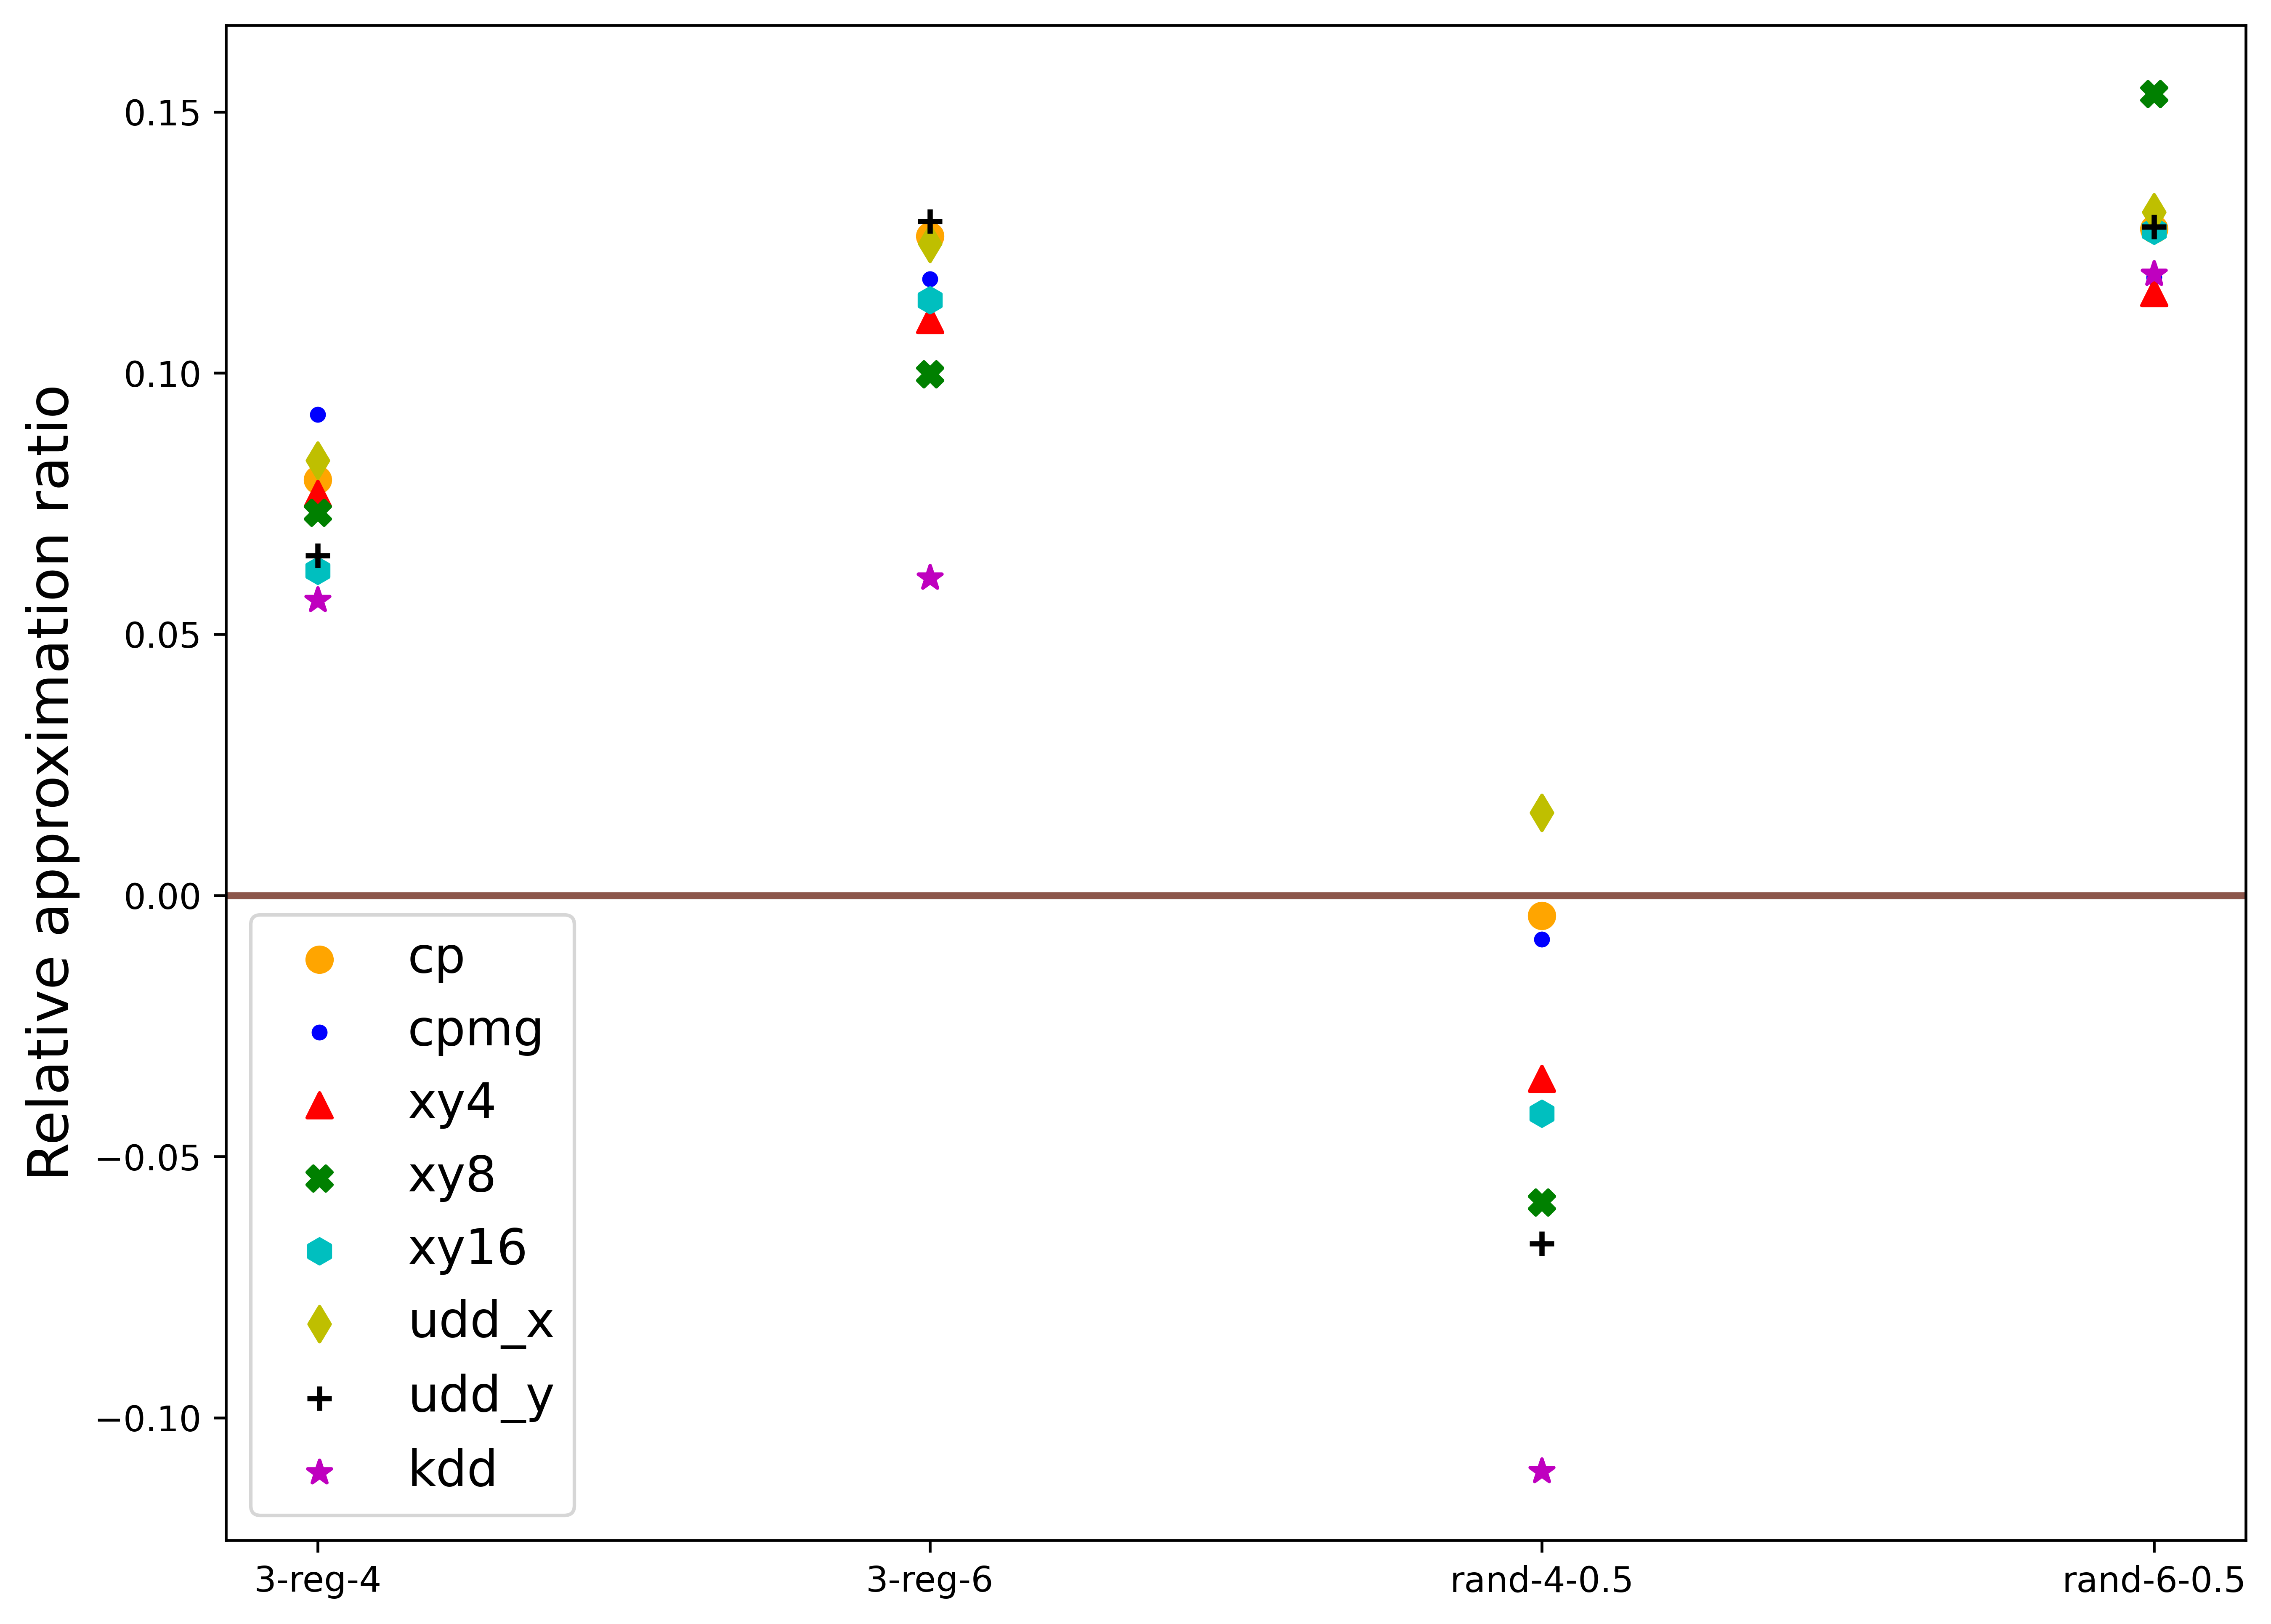

In [13]:
baseline = []
import numpy as np
import matplotlib.pyplot as plt
# name = ['Baseline', 'cp', 'cpmgl', 'xy4', 'xy8', 'xy16', 'udd_x_', 'udd_y', 'kdd',
#         'PE', 'cp_pe', 'cpmg_pe', 'xy4_pe', 'xy8_pe', 'xy16_pe', 'udd_x_pe', 'udd_y_pe','kdd_pe']

data = []
for name in graph_name:
    result_data = results_data[name]
    baseline.append(result_data[0])
    ratio = [i - result_data[0] for i in result_data[1:]]
    data.append(ratio)


data = np.array(data)
# hahn = data[:, 0]
cp = data[:, 2]
cpmg = data[:, 3]
xy4 = data[:, 4]
xy8 = data[:, 5]
xy16 = data[:, 6]
udd_X = data[:, 7]
udd_Y = data[:, 8]
kdd = data[:, 9]

pe = data[:, 10]
# hahn_to = data[:, 10]
cp_pe = data[:, 13]
cpmg_pe = data[:, 14]
xy4_pe = data[:, 15]
xy8_pe = data[:, 16]
xy16_pe = data[:, 17]
udd_X_pe = data[:, 18]
udd_Y_pe = data[:, 19]
kdd_pe = data[:, 20]
graph_name_x = ['3-reg-4', '3-reg-6',
              'rand-4-0.5', 'rand-6-0.5',]
x_ticks = graph_name_x
X = np.arange(len(x_ticks))

from matplotlib.pyplot import figure
fig = figure(num=None, figsize=(8, 6), dpi=600, facecolor='w', edgecolor='k')
ax = fig.add_axes([0,0,1,1])

# plt.plot(X, hahn, linestyle='--', marker='o', color='g', label='hahn')
plt.scatter(X, cp, s=50, marker='o', color='orange', label='cp')
plt.scatter(X, cpmg, s=50, marker='.', color='b', label='cpmg')
plt.scatter(X, xy4, s=50, marker='^', color='r', label='xy4')
plt.scatter(X, xy8, s=50, marker='X', color='g', label='xy8')
plt.scatter(X, xy16, s=50, marker='h', color='c', label='xy16')
plt.scatter(X, udd_X, s=50, marker='d', color='y', label='udd_x')
plt.scatter(X, udd_Y, s=50, marker='+', color='k', label='udd_y')
plt.scatter(X, kdd, s=50, marker='*', color='m', label='kdd')
# plt.plot(X, pe, linestyle='--', marker='>', color='c', label='pe')
# # plt.plot(X, hahn_to, linestyle='--', marker='s', color='m', label='hahn_to')
# plt.plot(X, cp_pe, linestyle='--', marker='P', color='tab:pink', label='cp_pe')
# plt.plot(X, cpmg_pe, linestyle='--', marker='h', color='tab:gray', label='cpmg_pe')
# plt.plot(X, xy4_pe, linestyle='--', marker='_', color='tab:purple', label='xy4_pe')
# plt.plot(X, xy8_pe, linestyle='--', marker='<', color='tab:cyan', label='xy8_pe')
# plt.plot(X, xy16_pe, linestyle='--', marker='8', color='lightgreen', label='xy16_pe')
# plt.plot(X, udd_X_pe, linestyle='--', marker='|', color='tab:brown', label='udd_x_pe')
# plt.plot(X, udd_Y_pe, linestyle='--', marker='X', color='tab:olive', label='udd_y_pe')
# plt.plot(X, kdd_pe, linestyle='--', marker='D', color='maroon', label='kdd_pe')

plt.axhline(0, color='tab:brown', lw=2)

plt.legend(loc='best', fontsize=14)
# ax.set_title('Relative approximate ratio with only DD sequences on ibmq_jakarta', fontsize=18)
ax.set_xticks(X)
ax.set_xticklabels(x_ticks)
ax.set_ylabel('Relative approximation ratio', fontsize=16)

plt.savefig('Relat_AR_jakarta_DD_0520_TQE.pdf', bbox_inches='tight', pad_inches=0)

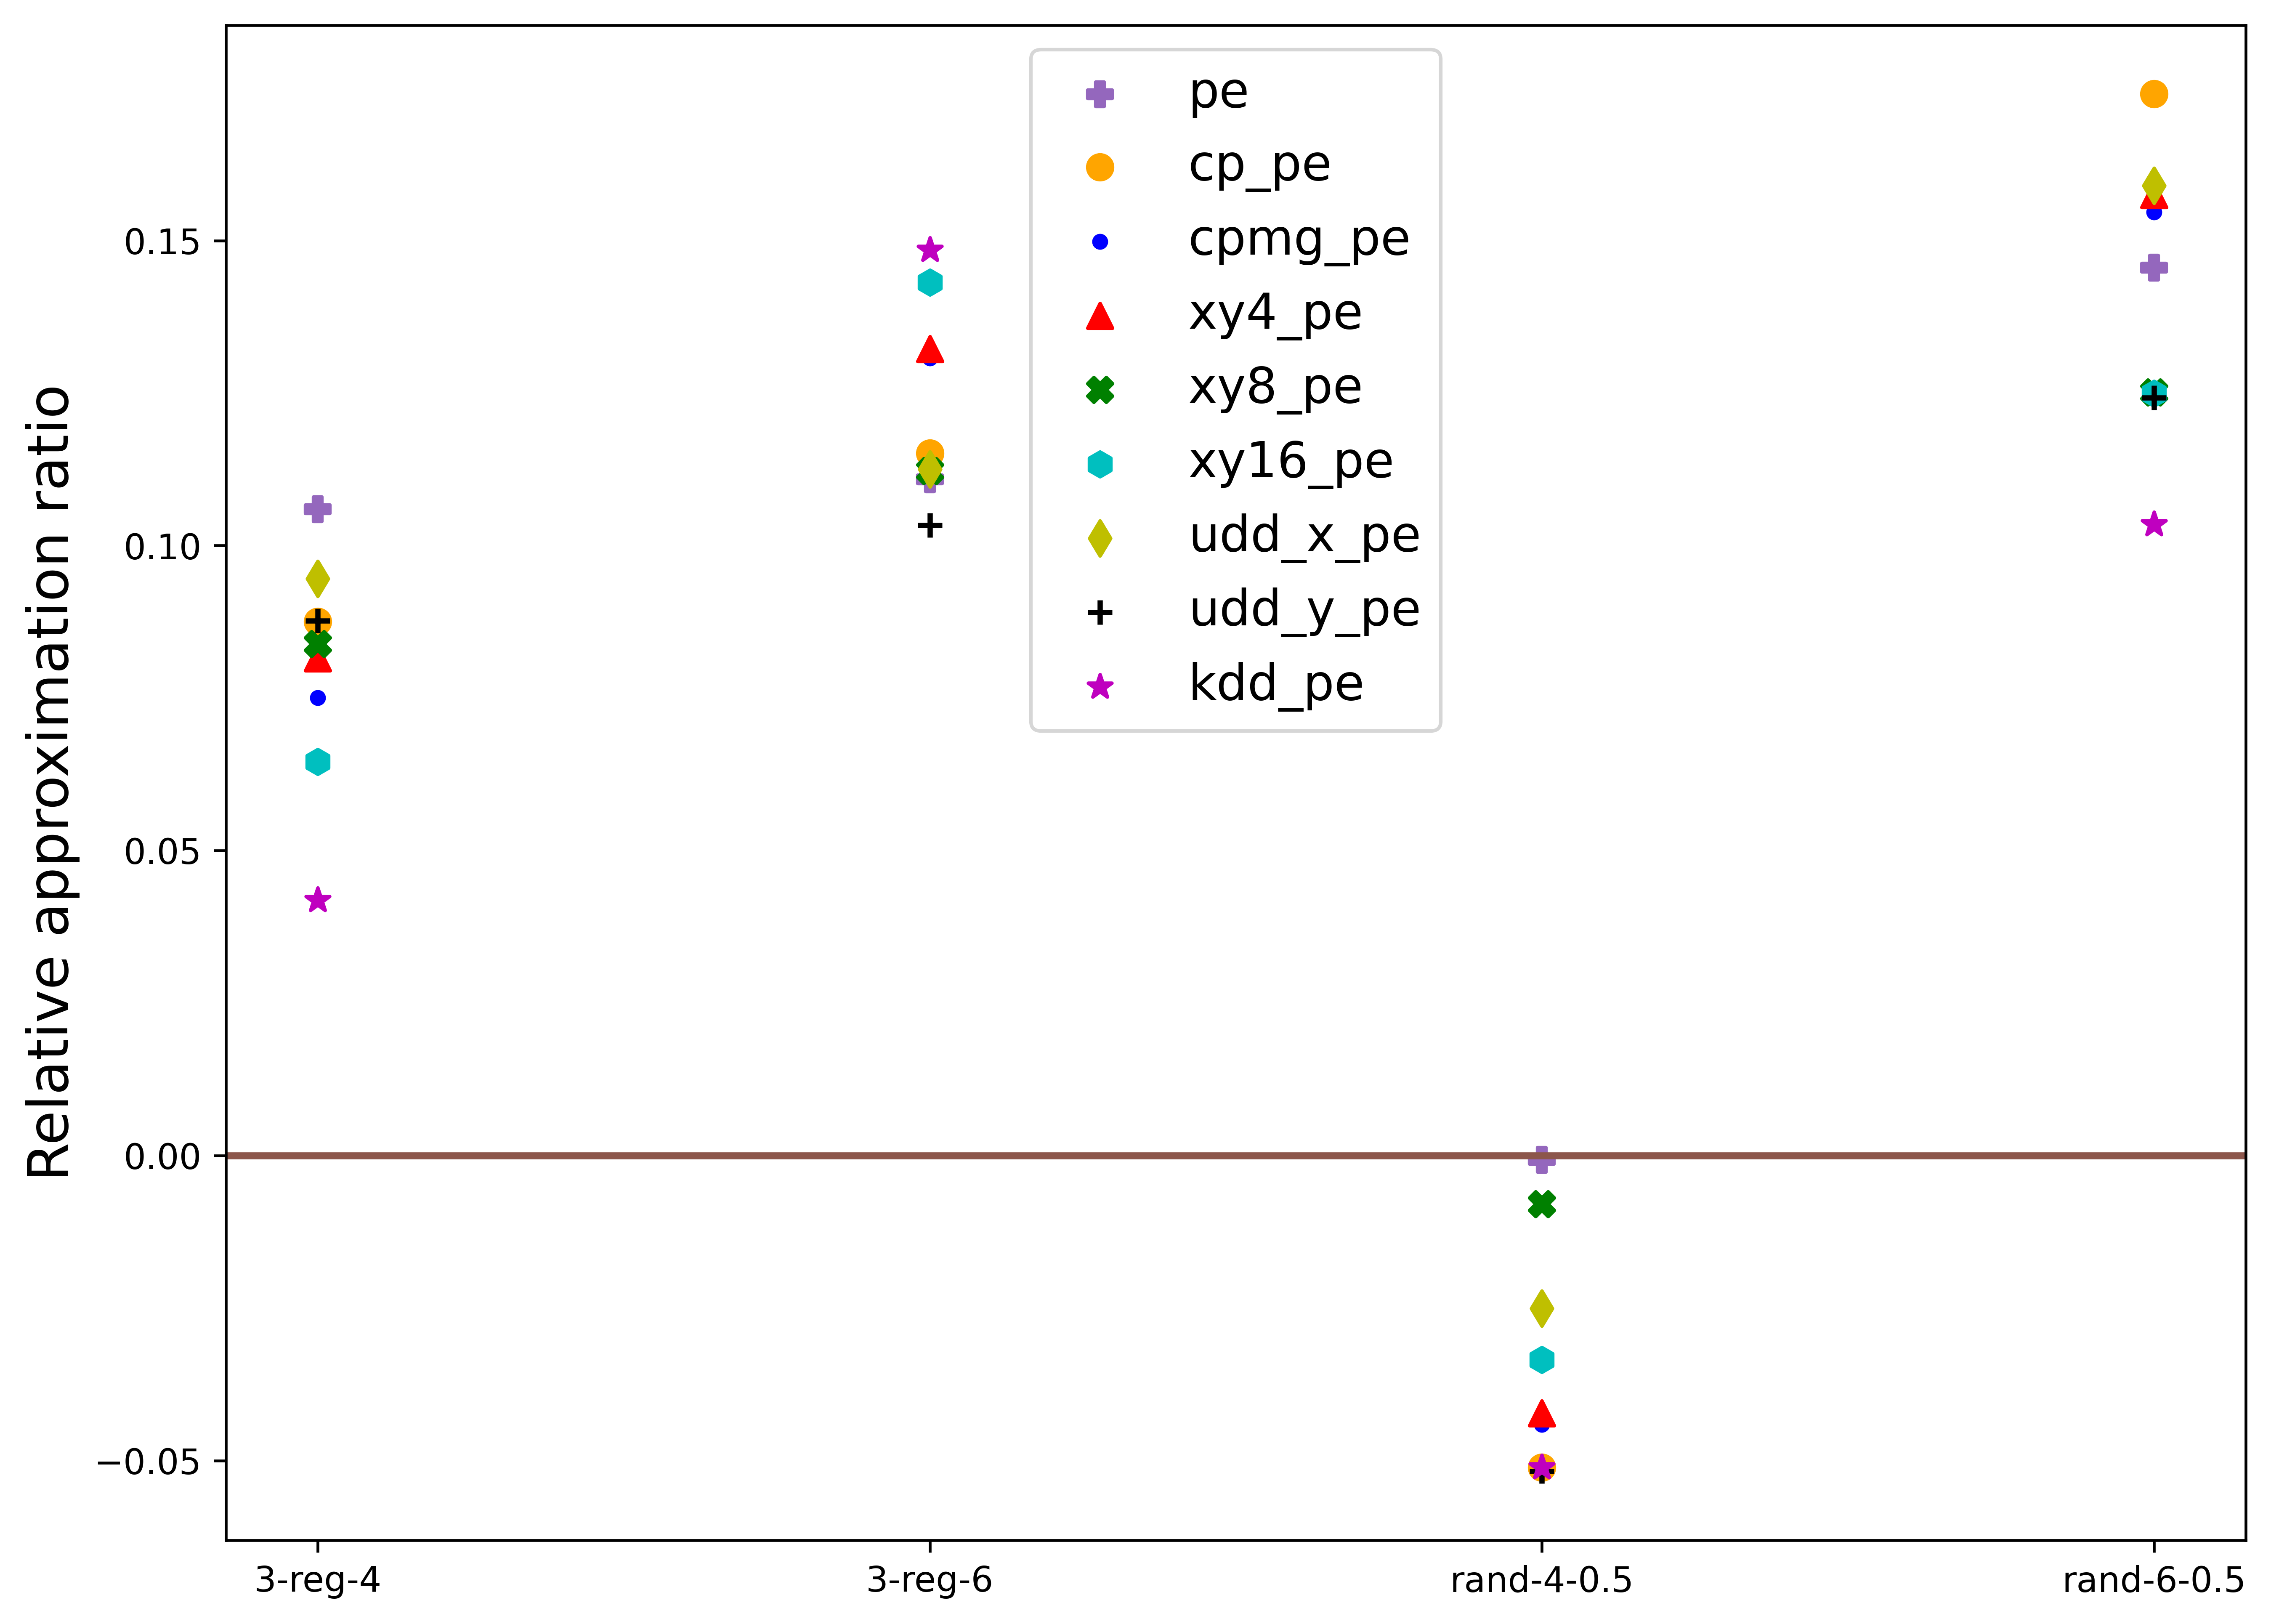

In [14]:
baseline = []

# name = ['Baseline', 'cp', 'cpmgl', 'xy4', 'xy8', 'xy16', 'udd_x_', 'udd_y', 'kdd',
#         'PE', 'cp_pe', 'cpmg_pe', 'xy4_pe', 'xy8_pe', 'xy16_pe', 'udd_x_pe', 'udd_y_pe','kdd_pe']

data = []
for name in graph_name:
    result_data = results_data[name]
    baseline.append(result_data[0])
    ratio = [i - result_data[0] for i in result_data[1:]]
    data.append(ratio)


data = np.array(data)
# hahn = data[:, 0]
cp = data[:, 2]
cpmg = data[:, 3]
xy4 = data[:, 4]
xy8 = data[:, 5]
xy16 = data[:, 6]
udd_X = data[:, 7]
udd_Y = data[:, 8]
kdd = data[:, 9]

pe = data[:, 10]
# hahn_to = data[:, 10]
cp_pe = data[:, 13]
cpmg_pe = data[:, 14]
xy4_pe = data[:, 15]
xy8_pe = data[:, 16]
xy16_pe = data[:, 17]
udd_X_pe = data[:, 18]
udd_Y_pe = data[:, 19]
kdd_pe = data[:, 20]

x_ticks = graph_name_x
X = np.arange(len(x_ticks))

from matplotlib.pyplot import figure
fig = figure(num=None, figsize=(8, 6), dpi=600, facecolor='w', edgecolor='k')
ax = fig.add_axes([0,0,1,1])

plt.scatter(X, pe, s=50, marker='P', color='tab:purple', label='pe')
# plt.plot(X, hahn_to, linestyle='--', marker='s', color='m', label='hahn_to')
plt.scatter(X, cp_pe, s=50, marker='o', color='orange', label='cp_pe')
plt.scatter(X, cpmg_pe, s=50, marker='.', color='b', label='cpmg_pe')
plt.scatter(X, xy4_pe, s=50, marker='^', color='r', label='xy4_pe')
plt.scatter(X, xy8_pe, s=50, marker='X', color='g', label='xy8_pe')
plt.scatter(X, xy16_pe, s=50, marker='h', color='c', label='xy16_pe')
plt.scatter(X, udd_X_pe, s=50, marker='d', color='y', label='udd_x_pe')
plt.scatter(X, udd_Y_pe, s=50, marker='+', color='k', label='udd_y_pe')
plt.scatter(X, kdd_pe, s=50, marker='*', color='m', label='kdd_pe')

plt.axhline(0, color='tab:brown', lw=2)

plt.legend(loc='best', fontsize=14)
# ax.set_title('Relative approximate ratio with DD sequences+pulse efficient on ibmq_jakarta', fontsize=18)
ax.set_xticks(X)
ax.set_xticklabels(x_ticks)
ax.set_ylabel('Relative approximation ratio', fontsize=16)

plt.savefig('Relat_AR_jakarta_DD_pe_0520_TQE.pdf', bbox_inches='tight', pad_inches=0)

In [24]:
name = ['Original_ideal', 'hahn_X_ideal', 'hahn_Y_ideal', 'cp_ideal', 'cpmg_ideal', 'xy4_ideal', 'xy8_ideal', 'xy16_ideal', 'udd_x_ideal', 'udd_y_ideal', 'KDD_ideal',
        'Original_pe', 'hahn_X_pe', 'hahn_Y_pe', 'cp_pe', 'cpmg_pe', 'xy4_pe', 'xy8_pe', 'xy16_pe', 'udd_x_pe', 'udd_y_pe', 'KDD_pe']
for i in range(2,21):
    print(name[i+1], data[:,i])
    print('average of improvement:',sum(data[:,i])/len(data[:,i]))
    print('----')

cp_ideal [ 0.07958984  0.1262207  -0.00390625  0.12760417]
average of improvement: 0.08237711588541666
----
cpmg_ideal [ 0.09204102  0.11796875 -0.00842285  0.11828613]
average of improvement: 0.07996826171875
----
xy4_ideal [ 0.0769043   0.11020508 -0.03503418  0.11535645]
average of improvement: 0.06685791015625
----
xy8_ideal [ 0.07324219  0.09980469 -0.05871582  0.15340169]
average of improvement: 0.06693318684895833
----
xy16_ideal [ 0.06213379  0.11391602 -0.04174805  0.12727865]
average of improvement: 0.06539510091145834
----
udd_x_ideal [0.08325195 0.12475586 0.01586914 0.13077799]
average of improvement: 0.08866373697916666
----
udd_y_ideal [ 0.06506348  0.12900391 -0.06665039  0.12801107]
average of improvement: 0.06385701497395835
----
KDD_ideal [ 0.05651855  0.06079102 -0.11022949  0.11897786]
average of improvement: 0.031514485677083336
----
Original_pe [ 0.10595703  0.11088867 -0.00073242  0.1455485 ]
average of improvement: 0.09041544596354167
----
hahn_X_pe [ 0.0842285

In [21]:
np.max(data)

0.17403157552083334

In [23]:
#only DD max value
np.max(data[:,2:10])

0.15340169270833334

In [22]:
(0.17403157552083334-0.15340169270833334)/0.15340169270833334

0.13448275862068965